# Predicting gender of movie directors using SSA baby names data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Hello and welcome to the third chapter of our exploration into the interplay between social networks, gender, and career success in the film industry. Specifically, we aim to discern how connections with network brokers—those pivotal individuals who bridge separate creative circles in the industry— impact the career trajectories of women and men movie directors differently.

**What are we aiming to do?**

In our previous work, we've identified a group of directors who began their careers between 2003 and 2013 (`Phase_1_Tracking_Movie_Directors_Career.ipynb`) and have constructed networks to measure the social influence of their collaborators (`Phase_2_Constructing_Filmmaker_Network.ipynb`). Now, we turn our focus toward another important part of our analysis: predicting the gender of these directors.

**How do we do it?**

To accomplish this, we will utilize the baby names dataset from the US Social Security Administration (SSA), which compiles names and their associated genders from national registration data. This resource allows us to infer the most likely gender associated with a director's first name, based on the proportion of male and female registrations for that name. For example, if over 95% of the individuals registered with a certain first name are female, we will predict the director's gender as female, and similarly for males. We'll also devise strategies for handling cases with initials or compound names.

It's important to acknowledge that while this project uses binary gender classifications for simplicity, gender identity is a diverse spectrum that extends beyond just male and female. This binary approach is used purely for analytical simplicity and is not intended as a statement negating the broader spectrum of gender identities.

**Looking ahead**

By the end of this notebook, we'll have established the predicted gender for each director in our sample. This will lay the groundwork for our next phase, where we will explore how the gender of a director might influence the benefits they gain from their network connections, particularly from those individuals who serve as bridges in the industry.

# Accessing SSA baby names data

We start with the Social Security Administration (SSA) Baby Names dataset. This dataset, which records baby names from 1880 to the present, reveals the gender distribution of names based on birth registrations. We access this information directly from its URL so that we don't need to store the data locally. This involves downloading a ZIP archive from the SSA's website, iterating through each `.txt` file within it, and compiling the names, genders, and occurrences into a single DataFrame.

In [1]:
# Import essential libraries 
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import os # interacting with the operating system, such as file paths
import requests # making HTTP requests to download files from the internet
import io # byte stream handling when dealing with binary data like files from a request
import zipfile # extracting files from ZIP archives
from unidecode import unidecode # normalizing unicode characters in strings to their ASCII counterparts
import dash # building interactive web applications
from dash import html, dcc # HTML components for building the layout and interactive components
import plotly.express as px # for high-level, easy-to-use plotting functions
from dash.dependencies import Input, Output # managing callbacks for interactive components

# Set the working directory to the location of project files
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [2]:
# Define the URL for the Social Security Administration (SSA) baby names dataset.
url_SSA = "https://www.ssa.gov/oact/babynames/names.zip"  

# Use requests to download the ZIP file from the SSA URL.
# The response content is a ZIP file containing yearly name data.
response = requests.get(url_SSA)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Initialize a DataFrame to hold the data for all years included in the SSA dataset
all_years_ssa_data = pd.DataFrame()

# Loop through each file within the zip archive, which contains names data for individual years
for filename in zip_file.namelist():
    if filename.endswith('.txt'):
        # Open the current file and read its content into a DataFrame
        with zip_file.open(filename) as file:
            year_data = pd.read_csv(file, names=['name', 'gender', 'count'])

        # Extract the year from the filename and add the year as a new column
        year = int(filename[3:7])  # Extract year from file name (e.g., 'yob2023.txt')
        year_data['year'] = year

        # Append the data from the current year to the all_years_ssa_data DataFrame
        all_years_ssa_data = pd.concat([all_years_ssa_data, year_data], ignore_index=True)


In [3]:
# Display the first few rows to check the combined data structure
all_years_ssa_data.head()

,name,gender,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


# Visualizing trends in name popularity

Before applying this data to predict the gender of movie directors, let's first explore some visualizations to understand trends in naming conventions over the years.

**Exploring the Most Popular Names**

To begin, let's delve into the five most popular names in our dataset. We'll map the number of babies with these names over time with line graphs, we can observe if they gained or lost popularity over the years.

In [84]:
# Aggregate the data by name and year, summing up counts for each name within each year.
# This step helps in identifying trends for each name over time.
name_trends = all_years_ssa_data.groupby(['name', 'year']).sum().reset_index()

# Identify the top 5 most frequent names across all years by summing the counts for each name and selecting the largest.
top_names = name_trends.groupby('name')['count'].sum().nlargest(5).index

# Filter the data to only include entries for these top names.
top_names_trend = name_trends[name_trends['name'].isin(top_names)]

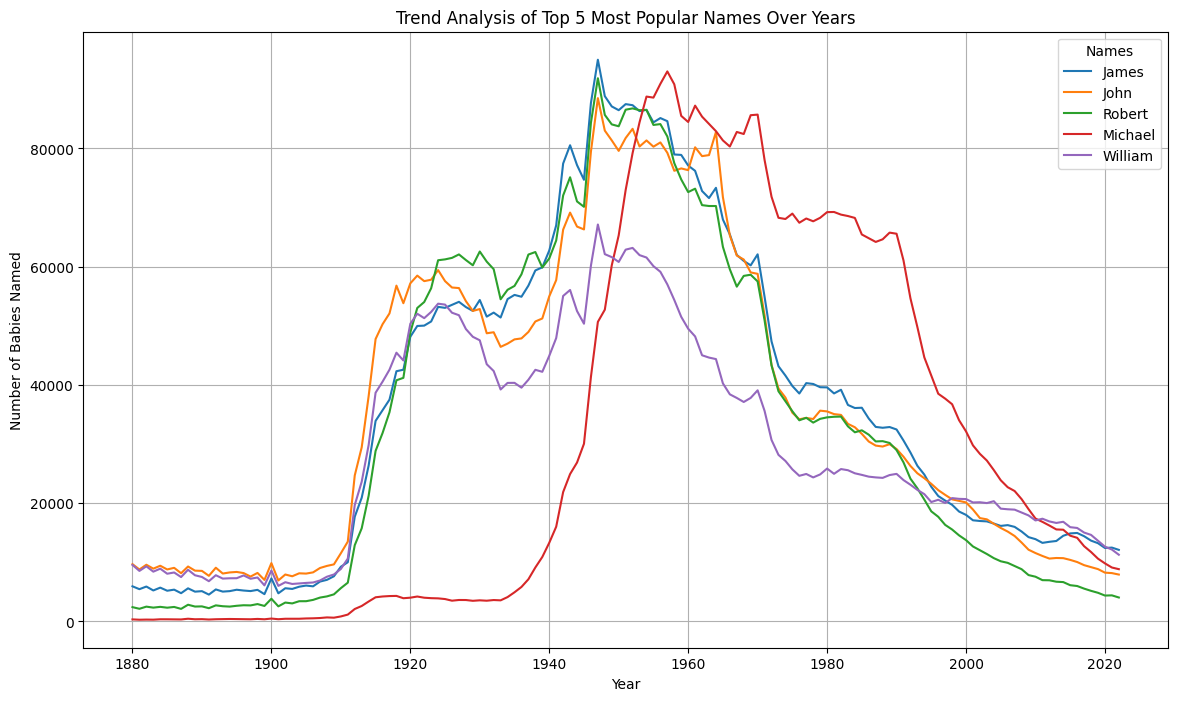

In [85]:
# Plotting the trends of these top names across the years.
# This visualization helps in understanding the popularity dynamics of these names.
plt.figure(figsize=(14, 8))
for name in top_names:
    data_to_plot = top_names_trend[top_names_trend['name'] == name]
    plt.plot(data_to_plot['year'], data_to_plot['count'], label=name)

plt.title('Trend Analysis of Top 5 Most Popular Names Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Babies Named')
plt.legend(title='Names')
plt.grid(True)
plt.show()

Interestingly, the number of babies with these names peaked around the 1950s but have declined since. However, this could be due to overall decreases in birth rates rather than a shift in preference for these names. To gain a clearer understanding, we'll analyze the proportion of newborns with these names relative to total births over time, rather than the raw counts. 

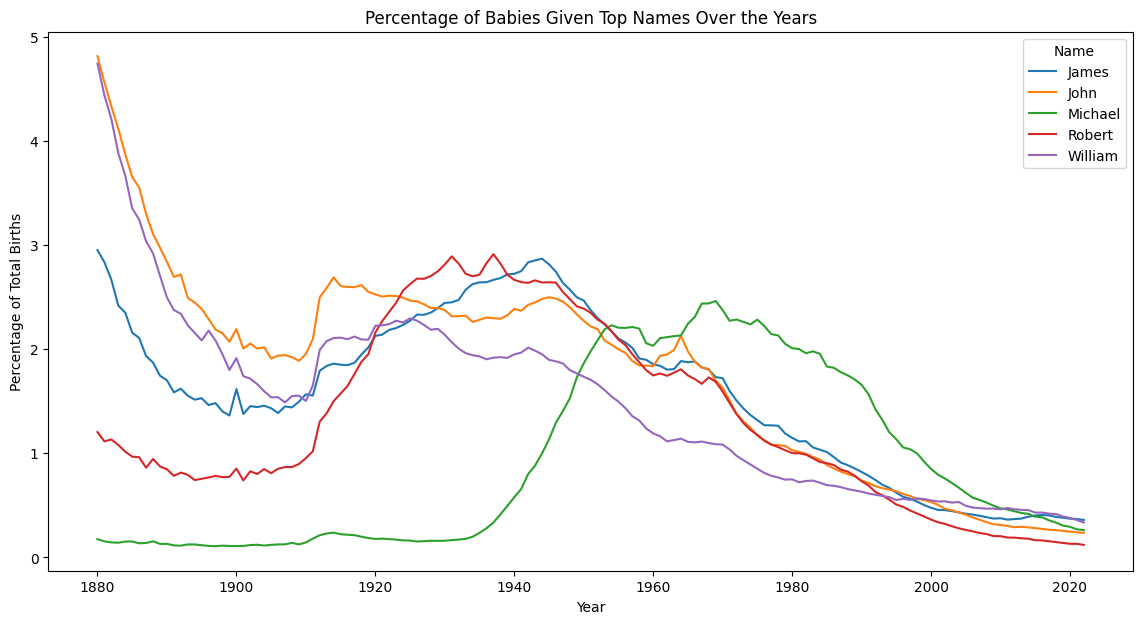

In [81]:
# Calculate total births per year
total_births_per_year = all_years_ssa_data.groupby('year')['count'].sum().reset_index()
total_births_per_year.rename(columns={'count': 'total_births'}, inplace=True)

# Merge with the top names data
top_names_trend = pd.merge(top_names_trend, total_births_per_year, on='year', how='left')

# Calculate the percentage
top_names_trend['percentage'] = (top_names_trend['count'] / top_names_trend['total_births']) * 100


# Visualizing name percentage  
plt.figure(figsize=(14, 7))
sns.lineplot(data=top_names_trend, x='year', y='percentage', hue='name')
plt.title('Percentage of Babies Given Top Names Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Births')
plt.legend(title='Name')
plt.show()


So, these names truly are becoming less popular over time, dropping in the percentage they account for starting since the 50s. 

One thing that is really strange is that all five of the most popular names are traditionally masculine names. Let's take a closer look at the 10 most popular names across the years to explore this issue further.

In [20]:
name_trends.groupby('name')['count'].sum().nlargest(10)

name
James      5238523
John       5180158
Robert     4858239
Michael    4423430
William    4183494
Mary       4149886
David      3667664
Joseph     2657975
Richard    2582274
Charles    2430018
Name: count, dtype: int64

When we expand our analysis to the top ten names, only one traditionally feminine name, Mary, appears. This raises a question: are names for girls more diverse, or are there inherently more male babies? To investigate this, let's plot the number of male and female babies registered each year in the SSA dataset, so that we can visualize trends in gender distribution over time.

Keep in mind though, the SSA dataset does not actually cover all babies born in the U.S. It only includes names given to more than five babies in a year to protect privacy. However, this dataset still covers a vast majority of newborns, as most parents in the U.S. register their children with the SSA soon after birth to get access to essential services like healthcare and education. Thus, while not perfect, the SSA dataset provides a robust source for analyzing trends in the number of male and female babies born each year.

In [ ]:
# Aggregate data by gender and year to analyze trends over time.
gender_yearly_data = all_years_ssa_data.groupby(['year', 'gender']).sum().reset_index()

# Transform the table to have years as rows and genders as columns for easier visualization
gender_yearly_data_pivot = gender_yearly_data.pivot(index='year', columns='gender', values='count')

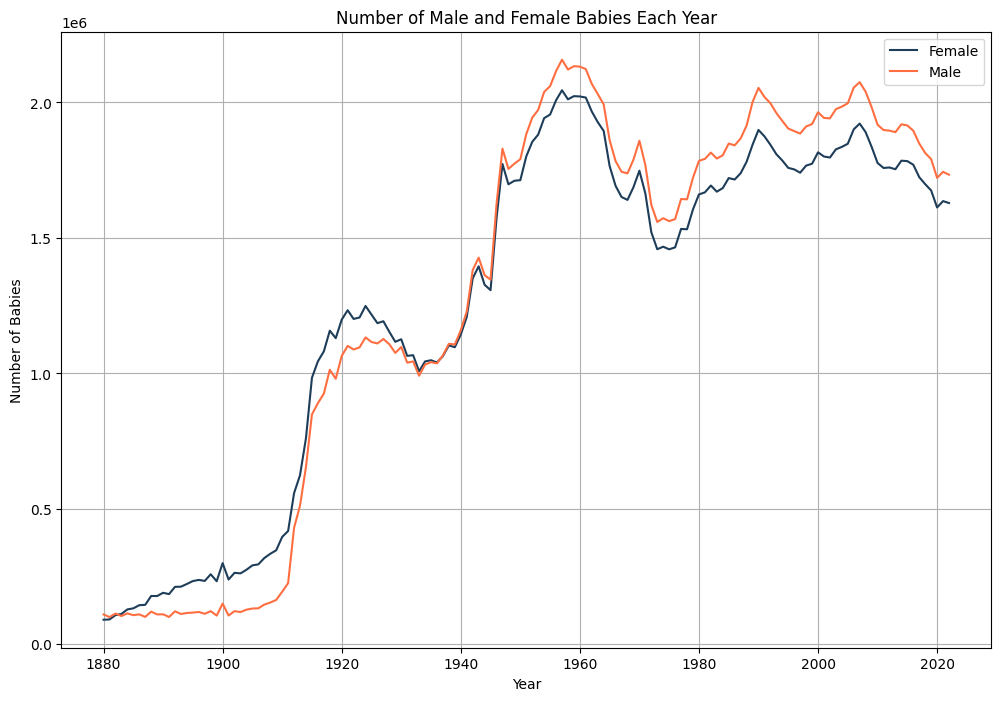

In [27]:
# Plot the data to compare the number of male and female babies each year.
plt.figure(figsize=(12, 8))
plt.plot(gender_yearly_data_pivot.index, gender_yearly_data_pivot['F'], label='Female', color='#1e3d59')
plt.plot(gender_yearly_data_pivot.index, gender_yearly_data_pivot['M'], label='Male', color='#ff6e40')
plt.title('Number of Male and Female Babies Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Babies')
plt.legend()
plt.grid(True)
plt.show()

It does seem like from the 1950s to now, more male babies are being registered with the SSA than female babies. Since each baby has an equal chance of being male or female, we would expect the numbers of male and female babies in the population to be roughly equal. So what explains this difference?

One reason for this might be due to the diversity in naming girls compared to boys. If parents are choosing highly unique names for daughters—names that appear only once or twice—they wouldn’t be captured in the dataset. This could indicate a cultural preference for more traditional, repeated use of male names and a broader variety of female names.

Another reason is that there are actually fewer girls than boys being born every year, possibly influenced by modern fertility treatments that allow parents to choose the sex of their child.

**Most popular names by gender**
Now let's turn our attention to more recent data and find the most popular names for boys and girls in recent years.

In [72]:
# Select data for a recent year (2022) and compare the top names for each gender
recent_year_data = all_years_ssa_data[all_years_ssa_data['year'] == 2022]
top_names_by_gender = recent_year_data.groupby(['name', 'gender'])['count'].sum().unstack().fillna(0).reset_index()

# Identify the top 10 female and male names for the selected year
top_female_names = top_names_by_gender.sort_values(by='F', ascending=False).head(10)
top_male_names = top_names_by_gender.sort_values(by='M', ascending=False).head(10)

In [73]:
top_female_names

gender,name,F,M
21564,Olivia,16573.00,16.00
8746,Emma,14435.00,15.00
5806,Charlotte,12891.00,10.00
1891,Amelia,12333.00,13.00
25282,Sophia,12310.00,12.00
11522,Isabella,11662.00,13.00
3504,Ava,11039.00,9.00
19571,Mia,11018.00,9.00
9223,Evelyn,9289.00,6.00
17774,Luna,8922.00,15.00


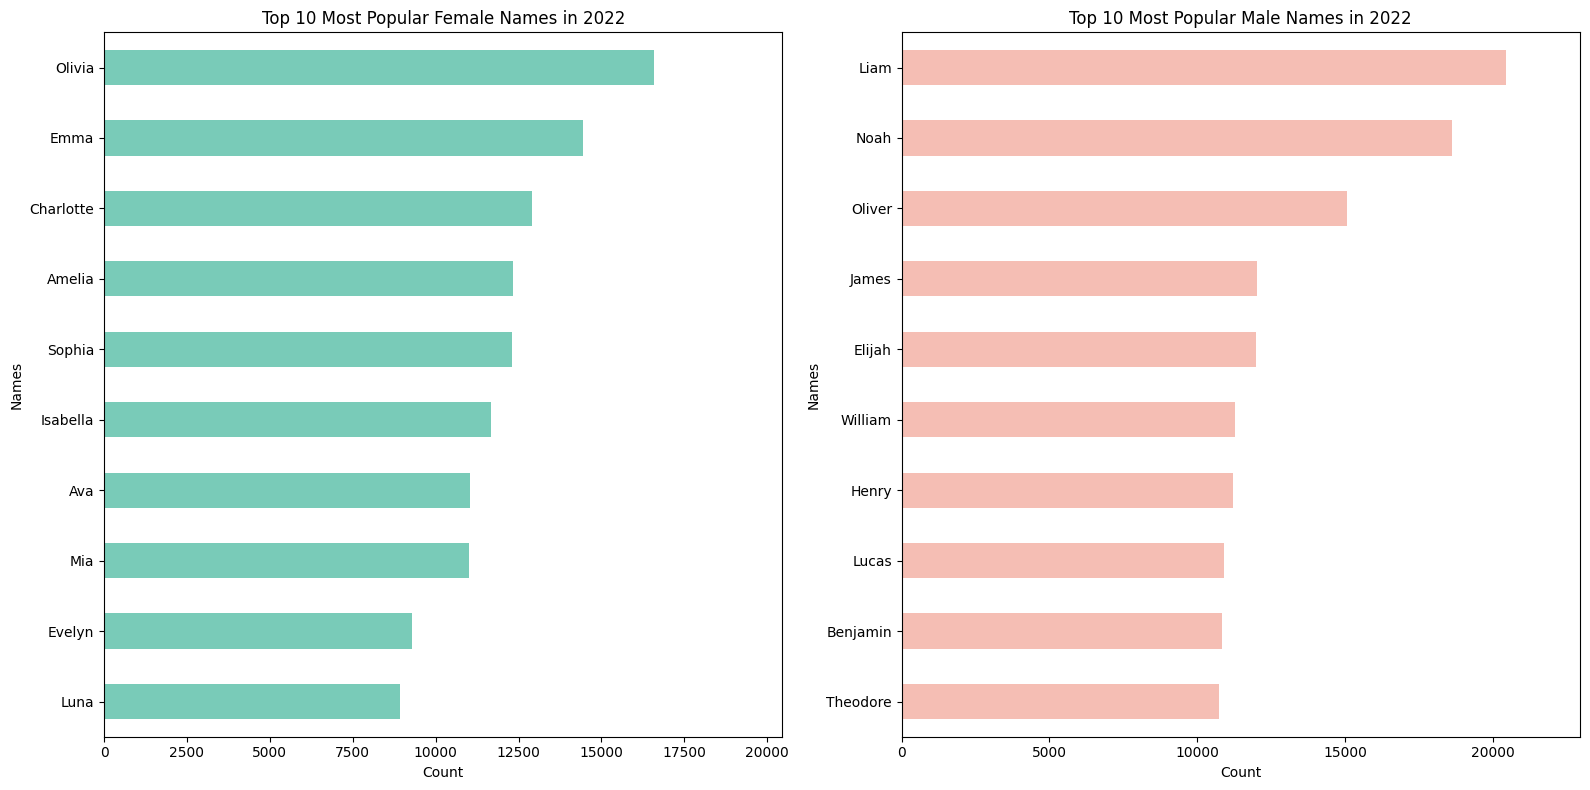

In [74]:
# Determine the maximum count for setting a consistent x-axis range across plots
max_count = max(top_female_names['F'].max(), top_male_names['M'].max())

# Create side-by-side horizontal bar plots to visually compare the top names
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot for top female names - horizontal bar
top_female_names.plot(kind='barh', x='name', y='F', ax=ax[0], color='#79cbb8', legend=False)
ax[0].set_title('Top 10 Most Popular Female Names in 2022')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Names')
ax[0].invert_yaxis()  # Invert y-axis to display the highest values at the top
ax[0].set_xlim(0, max_count)  # Set consistent x-axis range

# Plot for top male names - horizontal bar
top_male_names.plot(kind='barh', x='name', y='M', ax=ax[1], color='#f5beb4', legend=False)
ax[1].set_title('Top 10 Most Popular Male Names in 2022')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Names')
ax[1].invert_yaxis()  # Invert y-axis to display the highest values at the top
ax[1].set_xlim(0, max_count + 2500)  # Set consistent x-axis range

# Adjust layout for better fit and consistency
plt.tight_layout()
plt.show()


In 2022, 'Olivia' and 'Liam' were the frontrunners for girls and boys. 

We can also do this for every year in the data. For this, let's develop a web application using Dash, which allows us to dynamically select years and genders, and the graph will update accordingly to display the top 10 names for the chosen filters.

In [ ]:
# Initialize a Dash app to create an interactive web dashboard
app = dash.Dash(__name__)

# Set up dropdowns for selecting years and genders, and a graph component for displaying name trends
years = all_years_ssa_data['year'].unique()
genders = all_years_ssa_data['gender'].unique()

app.layout = html.Div([
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': year, 'value': year} for year in sorted(years)],
        value=years[0]  # Default selection is the first year available.
    ),
    dcc.Dropdown(
        id='gender-dropdown',
        options=[{'label': gender, 'value': gender} for gender in genders],
        value=genders[0]  # Default selection is the first gender available.
    ),
    dcc.Graph(id='name-trends-graph')
])

# Define callback functions to update the graph based on user input from dropdown menus
@app.callback(
    Output('name-trends-graph', 'figure'),
    Input('year-dropdown', 'value'),
    Input('gender-dropdown', 'value')
)
def update_graph(selected_year, selected_gender):
    # Filter data based on the selected year and gender
    filtered_data = all_years_ssa_data[(all_years_ssa_data['year'] == selected_year) & 
                                       (all_years_ssa_data['gender'] == selected_gender)]
    # Aggregate and select the top 10 names for the selected category
    top_names = filtered_data.groupby('name').sum().nlargest(10, 'count')
    # Create a bar chart for the top names
    fig = px.bar(top_names, x=top_names.index, y='count', title=f'Top 10 Names in {selected_year} for {selected_gender}',
                 color_discrete_sequence=['#317773' if selected_gender == 'F' else '#E2D1F9'])
    
    # plot layout
    fig.update_layout(
        plot_bgcolor='white',  # Set background color to white for readability
        paper_bgcolor='white'
    )
    return fig

# Run the server with debugging enabled
if __name__ == '__main__':
    app.run_server(debug=True)

One thing to note is that the interactive features of this dashboard cannot be viewed directly on GitHub. To interact with the dashboard, we will need to run this notebook on your local machine. If we wish to make this dashboard accessible to a broader audience without requiring them to run it locally, the application needs to be hosted on a web server. Hosting it on platforms like Heroku, AWS, or Google Cloud provides continuous access to the interactive features from anywhere with internet access. Maybe I'll do that some time in the future, for now, let's focus on the task at hand - gender prediction based on names.

# Gender classification with SSA data

Now we turn our attention to identifying the predominant gender association for each name in the SSA data, which includes the number of times a given name was assigned to a baby of a particular gender in a specific year. We'll consider a person as female (male) only if more than 95% of individuals with the same first name are female (male). To enact this classification, we need to calculate gender ratios for each name and write a function to classify them as 'Male' or 'Female' if the ratio for that gender is above 95%, otherwise, it is 'Ambiguous'.

In [4]:
# Aggregate the combined data by name and gender, summing the occurrences across all years to get a total count per name-gender combination
aggregated_ssa_data = all_years_ssa_data.groupby(['name', 'gender']).sum().reset_index().drop(columns=['year'])

# Set pandas display options to format float numbers in a more readable way
pd.set_option('display.float_format', '{:.2f}'.format)
# Display summary statistics for the count column to understand the distribution of name occurrences
aggregated_ssa_data[['count']].describe()

,count
count,113882.00
mean,3207.67
std,51507.72
min,5.00
25%,11.00
50%,46.00
75%,243.00
max,5214844.00


So, there are 113,882 unique name-gender pairs in the dataset. There is a wide range in the frequency of name occurrences, from as few as 5 to as many as over 5 million times. The majority of name-gender pairs (75%) appear less than 243 times, which means that a relatively small number of names are incredibly popular, while the majority of names are much less common.

In [5]:
# Aggregate the data by name and gender, summing up the counts to get a total count for each name-gender combination
name_gender_counts = aggregated_ssa_data.groupby(['name', 'gender']).agg(total_count=('count', 'sum')).reset_index()

# Pivot the data so that each row represents a unique name, with separate columns for male and female counts
name_gender_counts = name_gender_counts.pivot(index='name', columns='gender', values='total_count').fillna(0)

# Calculate the total counts by adding male and female counts together, and compute the ratio of each gender to the total
# This helps in determining the predominant gender association for each name
name_gender_counts['total'] = name_gender_counts.sum(axis=1)
name_gender_counts['male_ratio'] = name_gender_counts['M'] / name_gender_counts['total']
name_gender_counts['female_ratio'] = name_gender_counts['F'] / name_gender_counts['total']

# Define a function to classify the gender based on the calculated ratios
# A name is classified as 'Male' or 'Female' if the ratio for that gender is above 95%, otherwise, it is 'Ambiguous'
def classify_gender(row):
    if row['male_ratio'] > 0.95:
        return 'Male'
    elif row['female_ratio'] > 0.95:
        return 'Female'
    else:
        return 'Ambiguous'

# Apply the gender classification function to each row in the dataset
name_gender_counts['predicted_gender'] = name_gender_counts.apply(classify_gender, axis=1)

# Reset the index to turn the names from an index into a column again, so that this data can be merged with the directors data
name_gender_counts = name_gender_counts.reset_index()

In [6]:
name_gender_counts

gender,name,F,M,total,male_ratio,female_ratio,predicted_gender
0,Aaban,0.00,127.00,127.00,1.00,0.00,Male
1,Aabha,56.00,0.00,56.00,0.00,1.00,Female
2,Aabid,0.00,16.00,16.00,1.00,0.00,Male
3,Aabidah,5.00,0.00,5.00,0.00,1.00,Female
4,Aabir,0.00,19.00,19.00,1.00,0.00,Male
...,...,...,...,...,...,...,...
102444,Zyvion,0.00,5.00,5.00,1.00,0.00,Male
102445,Zyvon,0.00,7.00,7.00,1.00,0.00,Male
102446,Zyyanna,6.00,0.00,6.00,0.00,1.00,Female
102447,Zyyon,0.00,6.00,6.00,1.00,0.00,Male


Everything looks great! Each name is now associated with a gender group. 

Let's create bar charts to see which names are most popular in each predicted gender category (Female, Male, and Ambiguous). 

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_1145/3935667500.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total', y='name', data=top_10_female_names, ax=axes[0], palette='Blues')
/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_1145/3935667500.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total', y='name', data=top_10_male_names, ax=axes[1], palette='Reds')
/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_1145/3935667500.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total', y='

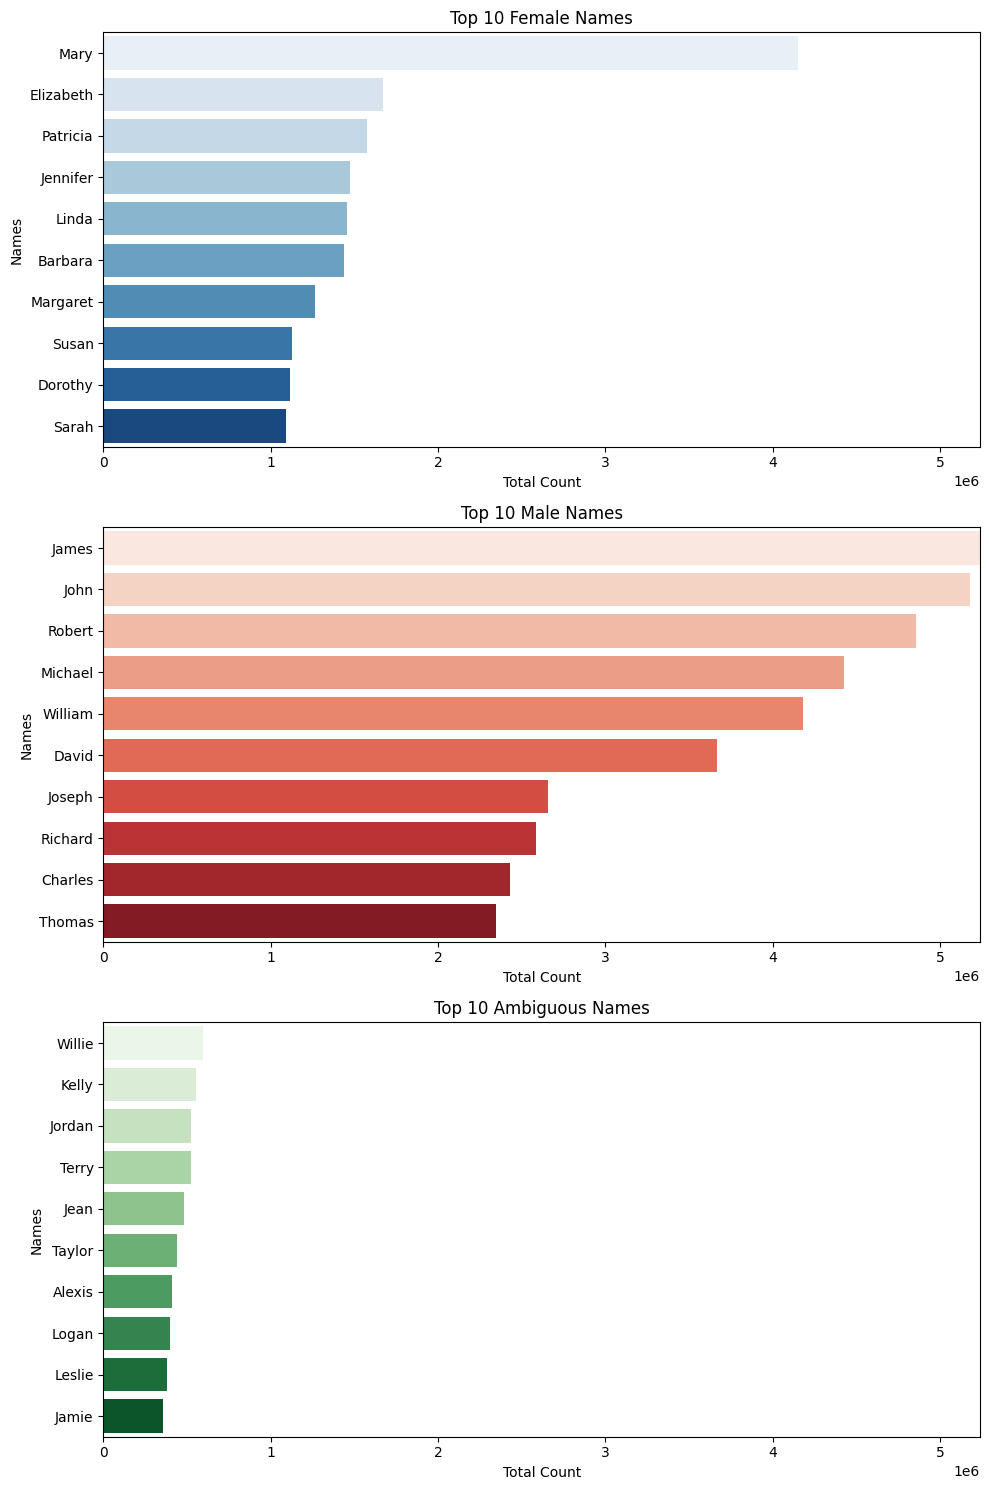

In [14]:
# Filter and select the top 10 names for each predicted gender category
top_10_female_names = name_gender_counts[name_gender_counts['predicted_gender'] == 'Female'].nlargest(10, 'total')
top_10_male_names = name_gender_counts[name_gender_counts['predicted_gender'] == 'Male'].nlargest(10, 'total')
top_10_ambiguous_names = name_gender_counts[name_gender_counts['predicted_gender'] == 'Ambiguous'].nlargest(10, 'total')

# Determine the maximum value for the x-axis across all categories
max_total = max(top_10_female_names['total'].max(), top_10_male_names['total'].max(), top_10_ambiguous_names['total'].max())

# Visualize the data using bar charts for each category with uniform x-axis scales
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Female Names
sns.barplot(x='total', y='name', data=top_10_female_names, ax=axes[0], palette='Blues')
axes[0].set_title('Top 10 Female Names')
axes[0].set_xlabel('Total Count')
axes[0].set_ylabel('Names')
axes[0].set_xlim(0, max_total)  # Set uniform x-axis limit

# Male Names
sns.barplot(x='total', y='name', data=top_10_male_names, ax=axes[1], palette='Reds')
axes[1].set_title('Top 10 Male Names')
axes[1].set_xlabel('Total Count')
axes[1].set_ylabel('Names')
axes[1].set_xlim(0, max_total)  # Set uniform x-axis limit

# Ambiguous Names
sns.barplot(x='total', y='name', data=top_10_ambiguous_names, ax=axes[2], palette='Greens')
axes[2].set_title('Top 10 Ambiguous Names')
axes[2].set_xlabel('Total Count')
axes[2].set_ylabel('Names')
axes[2].set_xlim(0, max_total)  # Set uniform x-axis limit

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Getting directors' first name

The next step to predicting directors' gender is to get their first name. For this, we'll use our `directors_full_filmography` dataset created in previous notebook (`Phase_1_Tracking_Movie_Directors_Career.ipynb`), which includes unique identifiers for each director. To attach real names to the identifiers, we pull from the IMDb's `name.basics.tsv.gz`, a comprehensive database that includes names of film industry professionals. By merging these two datasets on the IMDb unique identifier (`nconst`), we can map each director to their actual name. We then split the full name of directors to isolate the first name, which is more commonly indicative of gender.

To mitigate any discrepancies due to character encoding or typographical variations in name, we convert Unicode characters to their closest ASCII representation. This step is crucial for dealing with non-ASCII names which are common in a globally diverse dataset like IMDb. 


In [86]:
# Load the dataset containing movie directors' filmography from 2003 to 2023
directors_full_filmography = pd.read_csv('directors_full_filmography.csv')

# Display the first few rows of the data to understand the data structure
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.00,"Comedy,Mystery",nm1131265,2004.00,7.80,34.00
1,tt0108549,2004.00,"Comedy,Mystery",nm1130611,2004.00,7.80,34.00
2,tt0117461,2003.00,"Comedy,Romance",nm0290651,2003.00,6.30,24.00
3,tt0117743,2008.00,"Drama,Romance",nm0404033,2003.00,6.70,64.00
4,tt0118141,2005.00,Drama,nm0000417,2005.00,5.30,950.00


In [87]:
# Define the URL for the IMDb dataset that contains names of film industry professionals
url_name_basics = 'https://datasets.imdbws.com/name.basics.tsv.gz'
# Load selected columns ('nconst' for IMDb's unique identifier and 'primaryName' for the person's name) from the dataset
name_basics_df = pd.read_csv(url_name_basics, sep='\t', compression='gzip', encoding='utf-8', low_memory=False, usecols=['nconst', 'primaryName'])

# Merge the filmography dataset with the IMDb names dataset on the 'nconst' column to associate each director with their name
directors_name = directors_full_filmography[['nconst']].drop_duplicates().merge(name_basics_df, on='nconst', how='left')

In [88]:
# Display the first few rows of the data 
directors_name.head(10)

,nconst,primaryName
0,nm1131265,Steve Ashlee
1,nm1130611,Valerie Silver
2,nm0290651,Val Franco
3,nm0404033,Halfdan Hussey
4,nm0000417,Crispin Glover
5,nm0818538,Keith Spiegel
6,nm0425843,Mike Johnson
7,nm3084782,Arthur J. Mangano
8,nm0806102,Trace Slobotkin
9,nm6032566,Tony Luke


In [89]:
# Ensure the 'primaryName' column is treated as a string to avoid any type-related issues during processing
directors_name['primaryName'] = directors_name['primaryName'].astype(str)

# Normalize the director's first names to ensure consistency, important for non-ASCII names
# The 'unidecode' function converts unicode characters to their closest ASCII representation
# Splitting the 'primaryName' by space and selecting the first element isolates the first name
directors_name['director_first_name'] = directors_name['primaryName'].apply(unidecode).apply(lambda x: x.split()[0])

In [90]:
directors_name

,nconst,primaryName,director_first_name
0,nm1131265,Steve Ashlee,Steve
1,nm1130611,Valerie Silver,Valerie
2,nm0290651,Val Franco,Val
3,nm0404033,Halfdan Hussey,Halfdan
4,nm0000417,Crispin Glover,Crispin
...,...,...,...
63164,nm4394847,Krishna Maaya,Krishna
63165,nm10527671,Anwar Shahadat,Anwar
63166,nm10532602,Patricia Gérimont,Patricia
63167,nm4453202,Jean Claude Taburiaux,Jean


# Gender prediction

Next, let's apply the gender prediction we created using SSA data to the directors' first names to predict their genders.

For this, we'll merge the directors' dataset (`directors_name`), which includes their names and identifiers, with the gender prediction dataset (`name_gender_counts`) containing gender predictions for all first names in SSA data. This merge is based on the directors' first names and aims to assign a probable gender to each director based on statistically common gender associations for those names.

**Handling ambiguities**

Not all names will match directly from the SSA data. Some directors' names may not appear in the dataset for several reasons:
- Initials as First Names: Directors whose first names are represented by initials (e.g., 'J.P.', 'A.J.') pose a unique challenge. We create a function to extract a potential middle name when the first part of the name ends with a period, suggesting it's an initial. This middle name might offer a clearer gender indication, which we can then analyze using our pre-computed gender predictions.
- Compound First Names: Another group involves directors with compound first names (e.g., 'Anne-Marie', 'Jean-Luc'). For these names, we create function that splits the name into individual components, evaluates each part against our gender prediction data, and synthesizes a coherent gender prediction. If all components suggest a single gender, that gender is assigned. However, if the components yield mixed results or are inconclusive, the gender is marked as 'Ambiguous.'

After applying these methods to refine gender predictions, we combine the initial predictions with those adjusted for initials and compound names. The resulting dataset now more accurately represents the probable genders of the directors, complete with their identifiers and names. 

In [131]:
# Merge the gender prediction results with the directors dataset based on the directors' first names
directors_name = directors_name.merge(name_gender_counts[['name', 'predicted_gender']], left_on='director_first_name', right_on='name', how='left')

In [132]:
directors_name

,nconst,primaryName,director_first_name,name,predicted_gender
0,nm1131265,Steve Ashlee,Steve,Steve,Male
1,nm1130611,Valerie Silver,Valerie,Valerie,Female
2,nm0290651,Val Franco,Val,Val,Ambiguous
3,nm0404033,Halfdan Hussey,Halfdan,NaN,NaN
4,nm0000417,Crispin Glover,Crispin,Crispin,Male
...,...,...,...,...,...
63164,nm4394847,Krishna Maaya,Krishna,Krishna,Ambiguous
63165,nm10527671,Anwar Shahadat,Anwar,Anwar,Male
63166,nm10532602,Patricia Gérimont,Patricia,Patricia,Female
63167,nm4453202,Jean Claude Taburiaux,Jean,Jean,Ambiguous


So, some directors have a predicted gender but others do not since their names are not in the SSA dataset. Let's see how many are in this category.

In [133]:
# Count the frequency of each predicted gender category among the directors
directors_name['predicted_gender'].value_counts()

predicted_gender
Male         38705
Female       10311
Ambiguous     4860
Name: count, dtype: int64

Among 63169 directors, 53876 (85%) have a name match with the SSA data, 9293 do not. Let's create a separate dataset for directors without a gender prediction and work off that dataset to see if we can predict gender for directors who use initials as first name or who have compound first names.

In [135]:
# Separate directors with exact gender matches from those without a clear prediction
directors_exact_match = directors_name[directors_name['predicted_gender'].notna()]
directors_no_match = directors_name[directors_name['predicted_gender'].isna()]

In [148]:
directors_no_match

,nconst,primaryName,director_first_name,name,predicted_gender
3,nm0404033,Halfdan Hussey,Halfdan,NaN,NaN
50,nm0245315,MarieAnna Dvorak,MarieAnna,NaN,NaN
73,nm0046007,Aysun Bademsoy,Aysun,NaN,NaN
89,nm0486587,L. James Langlois,L.,NaN,NaN
99,nm0865379,Nickolay Todorov,Nickolay,NaN,NaN
...,...,...,...,...,...
63114,nm10477444,Sergej Aleksandrov,Sergej,NaN,NaN
63127,nm6512505,Dinakshie Priyasad,Dinakshie,NaN,NaN
63129,nm10464524,Sumith Galhena,Sumith,NaN,NaN
63133,nm10500950,Ranjith Jayasinghe,Ranjith,NaN,NaN


Now, let's write a function to identify the middle name of directors using initials as first name. We do this by checking if the first part of a name includes a period, indicating an intial and returning the second part of the name if a period is detected. Then we apply this function to our dataset on directors with no name match and create a separate dataset for directors using initials called `directors_initials_middle_match`.

In [143]:
# Define a function to extract a middle name when the director's name includes initials
def extract_middle_name(full_name):
    parts = full_name.split()
    # Check if the first part ends with a period, indicating an initial
    if len(parts) > 2 and parts[0].endswith('.'):
        return parts[1]  # Return the middle name if an initial is detected
    return None

# Apply the function to the subset of directors whose first names are initials, so that we can use their middle names for gender prediction.
directors_initials = directors_no_match[directors_no_match['director_first_name'].apply(lambda x: x.endswith('.'))]
directors_initials['middle_name'] = directors_initials['primaryName'].apply(extract_middle_name)
directors_initials_middle_match = directors_initials[directors_initials['middle_name'].notna()]

In [152]:
directors_initials_middle_match

,nconst,primaryName,director_first_name,name,predicted_gender,middle_name
89,nm0486587,L. James Langlois,L.,NaN,NaN,James
127,nm0808527,J. Jesses Smith,J.,NaN,NaN,Jesses
603,nm1852081,J. Marshall Craig,J.,NaN,NaN,Marshall
652,nm1281881,A. Blaine Miller,A.,NaN,NaN,Blaine
724,nm0184947,C. Jay Cox,C.,NaN,NaN,Jay
...,...,...,...,...,...,...
61506,nm8785527,S.D. Shri Ram Vasu,S.D.,NaN,NaN,Shri
61896,nm9131304,R. Allsion Jr.,R.,NaN,NaN,Allsion
62691,nm9978225,Hari. k. Chanduri,Hari.,NaN,NaN,k.
62730,nm10020812,P. Vijay Varma,P.,NaN,NaN,Vijay


Everything is in place for directors using initials! Now let's work on directors with compound first name. First, we create a separate dataset for these directors called `directors_compound` based on whether their first name contains a hyphen (-).

In [159]:
# Identify directors with compound first names 
directors_compound = directors_no_match[directors_no_match['director_first_name'].str.contains('-')]

In [160]:
directors_compound

,nconst,primaryName,director_first_name,name,predicted_gender
182,nm1008121,Sigur-Björn,Sigur-Bjorn,NaN,NaN
311,nm1125131,Jean-Baptiste Andrea,Jean-Baptiste,NaN,NaN
657,nm1417409,Woon-hak Baek,Woon-hak,NaN,NaN
686,nm9426285,Hyeon-jeong Kim,Hyeon-jeong,NaN,NaN
759,nm1305425,Kyeong-hyeong Kim,Kyeong-hyeong,NaN,NaN
...,...,...,...,...,...
62772,nm10046917,Ho-jae Lee,Ho-jae,NaN,NaN
62819,nm0134901,Jean-Louis Cap,Jean-Louis,NaN,NaN
62821,nm10091782,Kap-Jong Park,Kap-Jong,NaN,NaN
62946,nm4170371,Karl-Heinz Klopf,Karl-Heinz,NaN,NaN


For these cases, we split the compound first name, check the gender prediction for each part, and classify the name based on the gender predominance of its parts. If both parts have matches in the SSA data and both are predominantly of one gender, the name is classified as that gender; otherwise, it's classified as ambiguous. If neither parts have matches in the SSA data, we consider the concatenated form of the compound name.

In [161]:
# Use the previously aggregated gender predictions (name_gender_counts) to create a dictionary for easier lookup.
name_gender_dict = name_gender_counts.set_index('name')['predicted_gender'].to_dict()

# Define a function to handle compound names by trying to predict gender based on individual parts of the name.
def classify_compound_name(name):
    parts = name.split('-')
    genders = []
    
    # Attempt to match each part individually
    for part in parts:
        gender = name_gender_dict.get(part)
        if gender:
            genders.append(gender)
    
    # If any part does not have a match, try the compound name without the hyphen
    if len(genders) != len(parts):
        # Turn the second part of the compound name to lowercase, join without the hyphen
        joined_name = parts[0] + parts[1].lower() if len(parts) > 1 else parts[0]
        gender = name_gender_dict.get(joined_name, 'NA')  # Attempt to find a match for the joined name
        return gender  # Return the found gender or 'NA'
    
    # Original classification logic
    # Determine the gender based on the majority of matches for the name parts, marking as 'Ambiguous' if unclear.
    if genders.count('Male') > 0 and genders.count('Female') == 0:
        return 'Male'
    elif genders.count('Female') > 0 and genders.count('Male') == 0:
        return 'Female'
    else:
        return 'Ambiguous'

# Apply the compound name classification logic.
directors_compound['predicted_gender'] = directors_compound['director_first_name'].apply(classify_compound_name)
directors_compound_names_match = directors_compound[directors_compound['predicted_gender'].isin(['Male', 'Female', 'Ambiguous'])]

In [177]:
directors_compound_names_match

,nconst,primaryName,director_first_name,name,predicted_gender
311,nm1125131,Jean-Baptiste Andrea,Jean-Baptiste,NaN,Male
774,nm1158974,Jean-Luc François,Jean-Luc,NaN,Male
794,nm1310022,Jean-Luc Getreau,Jean-Luc,NaN,Male
807,nm0135269,Loren-Paul Caplin,Loren-Paul,NaN,Male
1165,nm0320868,Jacques-Rémy Girerd,Jacques-Remy,NaN,Male
...,...,...,...,...,...
62744,nm0732199,Jean-François Robin,Jean-Francois,NaN,Male
62819,nm0134901,Jean-Louis Cap,Jean-Louis,NaN,Male
62821,nm10091782,Kap-Jong Park,Kap-Jong,NaN,Male
62946,nm4170371,Karl-Heinz Klopf,Karl-Heinz,NaN,Male


Let's put everything together by combinining the datasets on directors with exact name match(`directors_exact_match`), directors using initials with a clear gender prediction (`directors_initials_middle_match`), and directors with compound names with a clear gender prediciton (`directors_compound_names_match`).

In [178]:
# Combine all directors with gender predictions, including those corrected by handling initials and compound names.
directors_gender = pd.concat([
    directors_exact_match[['nconst', 'primaryName', 'predicted_gender']],
    directors_initials_middle_match[['nconst', 'primaryName', 'predicted_gender']],
    directors_compound_names_match[['nconst', 'primaryName', 'predicted_gender']]
], ignore_index=True)

In [182]:
directors_gender

,nconst,primaryName,predicted_gender
0,nm1131265,Steve Ashlee,Male
1,nm1130611,Valerie Silver,Female
2,nm0290651,Val Franco,Ambiguous
3,nm0000417,Crispin Glover,Male
4,nm0818538,Keith Spiegel,Male
...,...,...,...
54648,nm0732199,Jean-François Robin,Male
54649,nm0134901,Jean-Louis Cap,Male
54650,nm10091782,Kap-Jong Park,Male
54651,nm4170371,Karl-Heinz Klopf,Male


Now we have data on the ID, full name, and predicted gender of 54,653 directors in our sample. Let's see how many directors are in each predicted gender group. 

In [181]:
# Count the distribution of predicted genders
directors_gender['predicted_gender'].value_counts()

predicted_gender
Male         39016
Female       10427
Ambiguous     4947
Name: count, dtype: int64

So among the 63,169 directors in our sample, 54,653 have name match with the SSA data. Among those with a name match, 71% are predicted as men, 19% as women, and 9% are categorized as ambigous since their first names are not predominantly associated with one gender group. 

Finally, let's save this data for future analysis examining the impact of gender with career outcomes.

In [183]:
# Save the final dataset with directors' gender predictions to a CSV file
directors_gender.to_csv("directors_gender.csv")